<a href="https://colab.research.google.com/github/NOURDINEEEE/Data_Science_Project1/blob/main/Data_viz_pandas_keras1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext google.colab.data_table

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.11.0
Running on TPU  ['10.70.224.114:8470']


In [7]:
import re
import numpy as np
from matplotlib import pyplot as plt

In [8]:
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [331, 331]

batch_size = 16 * tpu_strategy.num_replicas_in_sync

gcs_pattern = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]
        
def parse_tfrecord(example):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [5])
  return image_tensor, one_hot_class

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_training_dataset():
  dataset = load_dataset(train_fns)

  # Create some additional training images by randomly flipping and
  # increasing/decreasing the saturation of images in the training set. 
  def data_augment(image, one_hot_class):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

  # Prefetch the next batch while training (autotune prefetch buffer size).
  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO) 

training_dataset = get_training_dataset()
validation_dataset = load_dataset(validation_fns).batch(batch_size).prefetch(AUTO)

In [9]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  
# If model is provided, use it to generate predictions.
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)

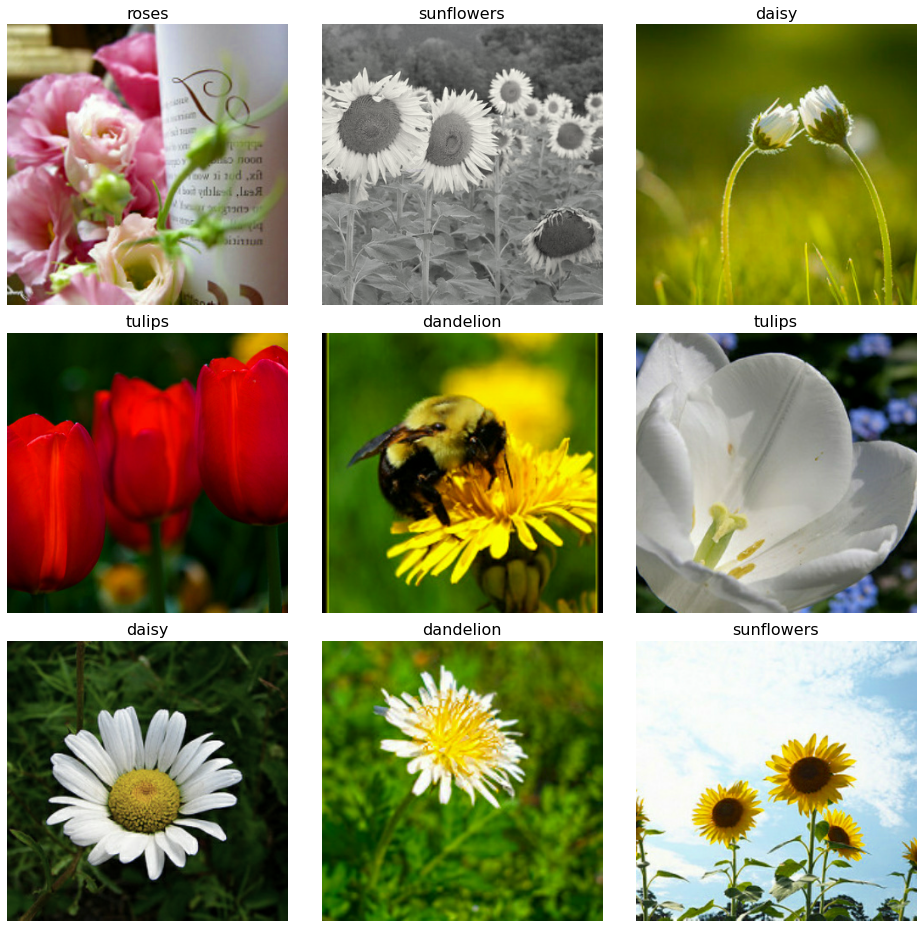

In [11]:
# Re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)

In [12]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 11, 11, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [13]:
def count_data_items(filenames):
  # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)

n_train = count_data_items(train_fns)
n_valid = count_data_items(validation_fns)
train_steps = count_data_items(train_fns) // batch_size
print("TRAINING IMAGES: ", n_train, ", STEPS PER EPOCH: ", train_steps)
print("VALIDATION IMAGES: ", n_valid)

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680


Learning rate per epoch:


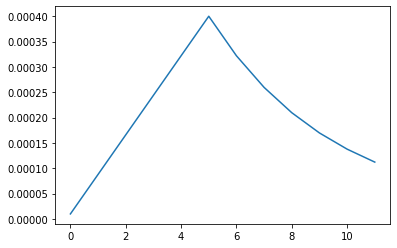

In [14]:
EPOCHS = 12

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [15]:
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/12
23/23 [==============================] - 77s 903ms/step - loss: 1.5935 - accuracy: 0.2704 - val_loss: 1.4782 - val_accuracy: 0.4368 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/12
23/23 [==============================] - 7s 298ms/step - loss: 0.8252 - accuracy: 0.7901 - val_loss: 0.3899 - val_accuracy: 0.8824 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/12
23/23 [==============================] - 7s 320ms/step - loss: 0.2606 - accuracy: 0.9195 - val_loss: 0.2084 - val_accuracy: 0.9221 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/12
23/23 [==============================] - 7s 306ms/step - loss: 0.1418 - accuracy: 0.9582 - val_loss: 0.1806 - val_accuracy: 0.9324 - lr: 2.4400e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/12
23/23 [==============

<ipython-input-16-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


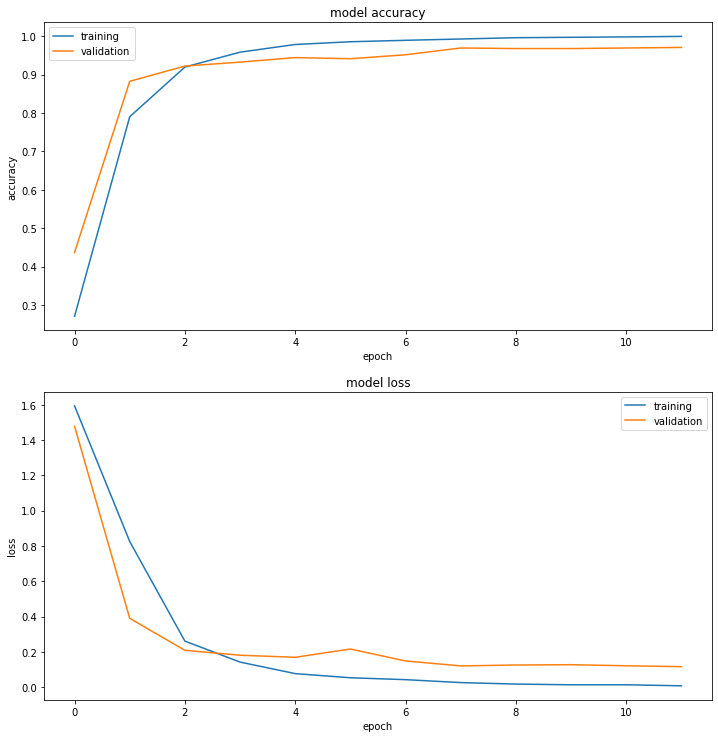

In [16]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [17]:
def flower_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = flower_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

validation_viz_iterator = get_dataset_iterator(validation_dataset, 9)

1/1 [==============================] - 11s 11s/step


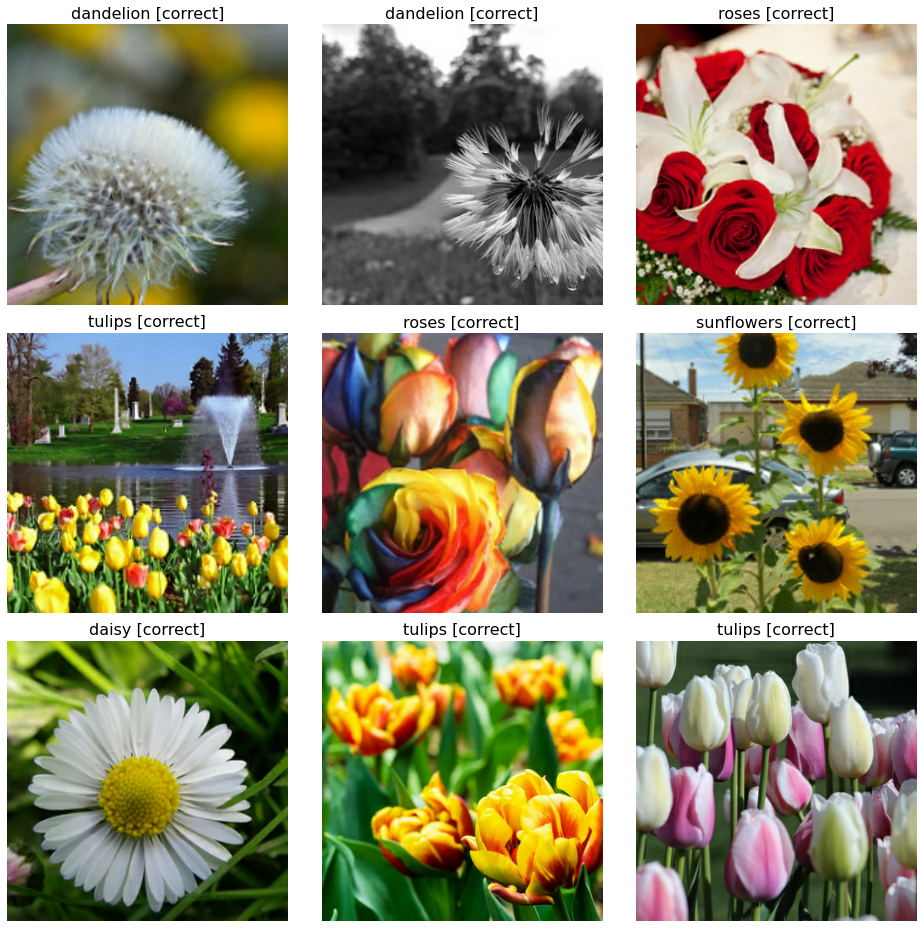

In [18]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)
display_nine_flowers(images, titles, colors)

In [19]:
# We can save our model with:
model.save('model.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model.h5')

1/1 [==============================] - 1s 1s/step


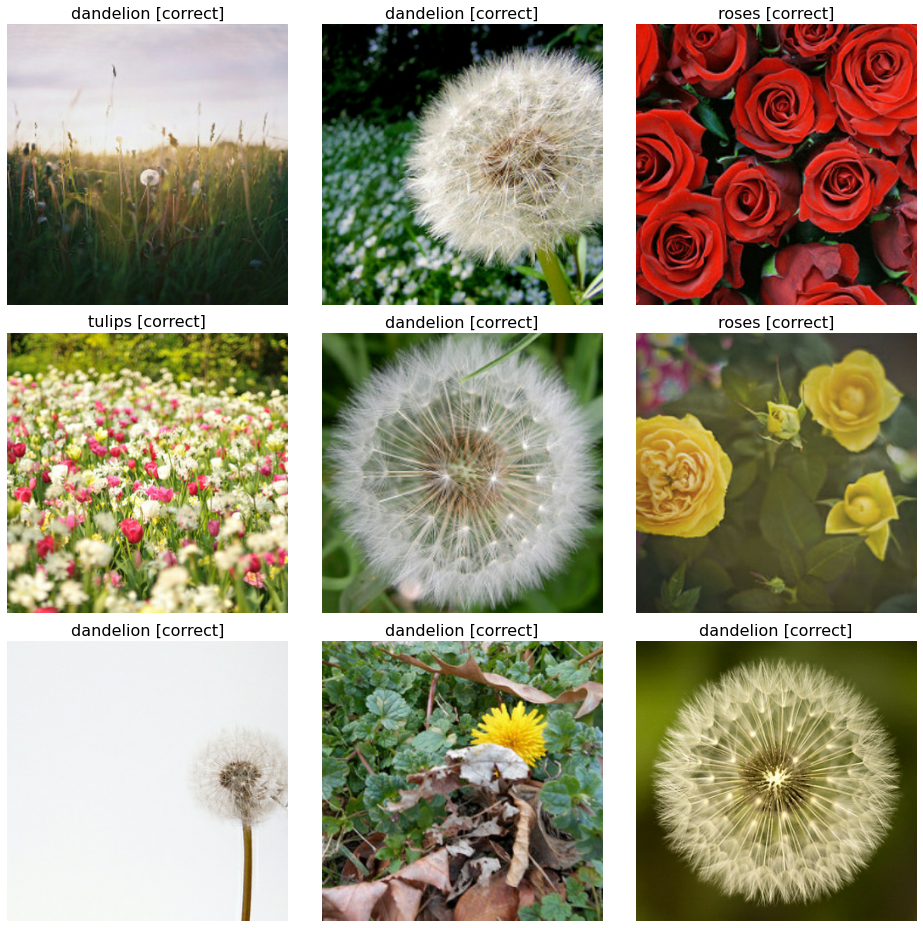

In [20]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, reloaded_model)
display_nine_flowers(images, titles, colors)

In [22]:
import numpy as np
import pandas as pd

RA = np.random.randint(101, size=(3, 4))

#my_data1 = np.array([[RA, RA, RA, RA], [RA, RA, RA, RA], [RA, RA, RA, RA]])

my_column_names = ['Eleonor', 'Chidi', 'Tahani', 'Jason']

my_dataframe = pd.DataFrame(data=RA, columns=my_column_names)

print(my_dataframe, '\n', "la valeur est", my_dataframe.iloc[[1]]['Eleonor'])

print(str(my_dataframe.iloc[[1]]['Eleonor'].to_list()))


   Eleonor  Chidi  Tahani  Jason
0       45     44      22     28
1       91     90      27     45
2       19     40      10     43 
 la valeur est 1    91
Name: Eleonor, dtype: int64
[91]


In [29]:
RA = np.random.randint(101, size=(3, 4))

#my_data1 = np.array([[RA, RA, RA, RA], [RA, RA, RA, RA], [RA, RA, RA, RA]])

my_column_names = ['Eleonor', 'Chidi', 'Tahani', 'Jason']

my_dataframe = pd.DataFrame(data=RA, columns=my_column_names)

print("\nSecond row of the Eleanor column: %d\n" % my_dataframe['Eleonor'][1])

my_dataframe['Janet'] = my_dataframe['Tahani'] + my_dataframe['Jason']

my_dataframe


Second row of the Eleanor column: 55



Eleonor  Chidi  Tahani  Jason  Janet
0        5     15      63     80    143
1       55     54      50     70    120
2       88     65      80     36    116